# Assignment 6 - Object recognition in images with deep learning

## Goals

In this assignment you will get to know the main ingredients of deep learning and get to use the GPUs available in the Big Data Lab.

You'll learn to use

 * tensors and automatic differentiation
 * layered models
 * p(re)trained networks for image classification.

## Check the GPU setup

When you are logged in to a lab machine, run ``nvidia-smi`` to see the available card and its memory usage.

```
$ nvidia-smi
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.102.04   Driver Version: 450.102.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 105...  Off  | 00000000:01:00.0  On |                  N/A |
| 45%   24C    P8    N/A /  75W |   3087MiB /  4038MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU       PID   Type   Process name                             Usage      |
|=============================================================================|
|    0      3627      G   /usr/lib/xorg/Xorg                           169MiB |
|    0     10843      C   ...d/CMPT/big-data/tmp_py/dlenv/bin/python  2897MiB |
+-----------------------------------------------------------------------------+
```

This shows that the machine has an **NVIDIA GTX 1050 with 4G of RAM**. Also, you can see that it is running a process (pid=10843) that currently takes up close to 3 GB of GPU memory. On our current `blu9402` lab machines you will notice a difference, as they have 8GB of RAM.

```
$ pstree -ls 10843
screen───bash───jupyter-noteboo───python─┬─4*[python]
                                         └─26*[{python}]
```
Inside a terminal window you may use ``who``, ``ps -aux | less``, or ``pstree -ls <PID>`` as above to find out who is using the shared resources. In my case, it turns out that I'm running a jupyter notebook related to process 10843. Halting the notebook frees up the GPU memory. 

## PyTorch setup in the lab

To build deep learning models in this assignment we are using **[PyTorch](http://pytorch.org)**, a replacement for numpy that provides accelerated computation on the GPU, automatic differentiation, and various utilities to train and deploy neural networks. Its popularity relative to [tensorflow](http://tensorflow.org) has been steadily increasing and it also has a high-level API, the [NN module](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html) similar to [tf.keras](https://www.tensorflow.org/api_docs/python/tf/keras).

In case you have trouble configuring a conda environment that has a CUDA version of pytorch installed, you could use the one that's provided under the prefix  
`conda activate /usr/shared/CMPT/big-data/condaenv/nn11`

### Save disk space in the lab: Use shared downloaded pre-built models
To save disk space in your home folder, we recommend that you let pytorch use the pre-built models that we already downloaded for you (about 1.9G):
```
mkdir -p ~/.cache/torch/hub/checkpoints
ln -s /usr/shared/CMPT/big-data/dot_torch_shared/checkpoints/* ~/.cache/torch/hub/checkpoints
```

## Learn about Pytorch usage

To familiarize yourself with PyTorch, have a look at the [Examples](http://pytorch.org/tutorials/beginner/pytorch_with_examples.html) on Tensors, or the NN module, or briefly skim over the [60 min blitz tutorial](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html).

# Task 1: Finding rectangles

A nice [**blog-post** by Johannes Rieke](https://towardsdatascience.com/object-detection-with-neural-networks-a4e2c46b4491) presents a simple setup from scratch that finds rectangles in a black & white image. In order to play with it, we just have to translate a few calls from Keras to PyTorch.

To familiarize yourself with using pytorch, have a look at the [Examples](http://pytorch.org/tutorials/beginner/pytorch_with_examples.html). The following code is preparing our training setup.

In [73]:
# to check GPU memory, uncomment and run the following line
!{'nvidia-smi'}

Fri Mar  1 16:03:01 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Quadro RTX 4000                 On | 00000000:01:00.0 Off |                  N/A |
| 30%   33C    P8                6W / 125W|   3454MiB /  8192MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [74]:
import numpy as np
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import matplotlib

# Create images with random rectangles and bounding boxes. 
num_imgs = 50000

img_size = 8
min_object_size = 1
max_object_size = 4
num_objects = 1

bboxes = np.zeros((num_imgs, num_objects, 4))
imgs = np.zeros((num_imgs, img_size, img_size))  # set background to 0

for i_img in range(num_imgs):
    for i_object in range(num_objects):
        w, h = np.random.randint(min_object_size, max_object_size, size=2)
        x = np.random.randint(0, img_size - w)
        y = np.random.randint(0, img_size - h)
        imgs[i_img, x:x+w, y:y+h] = 1.  # set rectangle to 1
        bboxes[i_img, i_object] = [x, y, w, h]

display(Markdown(f"The training data consists of ${num_imgs:,}$ example images.  \n"
                 f"`imgs` is an array of shape {imgs.shape}, giving an ${img_size}\\times{img_size}$ pixel image for each example.  \n"
                 f"`bboxes` is an array of shape {bboxes.shape}, giving a $1\\times4$ row vector [x, y, w, h] for each rectangle."
                ))
display(Markdown('**Here is an example of the training data:**'))
i = 0
plt.imshow(imgs[i].T, cmap='Greys', interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
for bbox in bboxes[i]:
    plt.gca().add_patch(matplotlib.patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], ec='r', fc='none', lw=2))

The training data consists of $50,000$ example images.  
`imgs` is an array of shape (50000, 8, 8), giving an $8\times8$ pixel image for each example.  
`bboxes` is an array of shape (50000, 1, 4), giving a $1\times4$ row vector [x, y, w, h] for each rectangle.

**Here is an example of the training data:**

In [75]:
# Reshape and normalize the image data to mean 0 and std 1. 
X = (imgs.reshape(num_imgs, -1) - np.mean(imgs)) / np.std(imgs)
display(Markdown(f"New shape of `imgs`: {X.shape}, with normalized mean {np.mean(X):.2f} and stdev {np.std(X):.2f}"))

# Normalize x, y, w, h by img_size, so that all values are between 0 and 1.
# Important: Do not shift to negative values (e.g. by setting to mean 0), because the IOU calculation needs positive w and h.
y = bboxes.reshape(num_imgs, -1) / img_size
y.shape, np.mean(y), np.std(y)

# Split training and test.
i = int(0.8 * num_imgs)
train_X = X[:i]
test_X = X[i:]
train_y = y[:i]
test_y = y[i:]
test_imgs = imgs[i:]
test_bboxes = bboxes[i:]

New shape of `imgs`: (50000, 64), with normalized mean -0.00 and stdev 1.00

## Task 1a
**Construct a Pytorch model that resembles the Keras one in the original blog post**, i.e. have a fully connected, hidden layer with 200 neurons, ReLU nonlinearity and dropout rate of 20%.

In [76]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(64, 200),
            nn.ReLU(),
            nn.Dropout(0.01),
            nn.Linear(200, 4),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)

Using cuda device


In [77]:
# Instantiate the adadelta optimizer with the models parameters
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # You can adjust the learning rate and other parameters as needed. # AdamW ~ .5, Adam ~ .49, Adagrad ~ 0.63, Adamax ~ .49, ASGD ~ nan, 
# Instantiate the loss function as MSE
# Sum the losses over all instances in the batch, rather than averaged.
loss_fn = torch.nn.MSELoss(reduction='sum')

In [78]:
# Prepare train data for testing
inputs = torch.Tensor(train_X).to(device)
labels = torch.Tensor(train_y).to(device)

# Prepare test data for evaluation
inputs_test = torch.Tensor(test_X).to(device)
labels_test = torch.Tensor(test_y).to(device)

In [79]:
phase = 'train'
model.train()
do_test_loss = False

loss_record = []
loss_test_record = []
for epoch in range(200):     # 30 Epochs (passes through the training dataset) of training
    optimizer.zero_grad()   # Clear old gradients from the last step (or the initial step) before the loss calculation of the current step.
    outputs = model(inputs) # Feed the input tensor through the model to obtain predictions (outputs)
    loss = loss_fn(outputs, labels) # Computes the loss by comparing the model's predictions (outputs) against the true labels using the loss function
    loss_record.append(loss.item()) # Record the current loss value. Using .item() converts the tensor to a Python number

    if phase == 'train':
        loss.backward()     # Calculate the gradient of the loss function with respect to the model parameters
        optimizer.step()    # Update the model's parameters based on the gradients computed by .backward()
    
    if do_test_loss:
        with torch.no_grad():
            outputs_test = model(inputs_test)
            loss_test = loss_fn(outputs_test, labels_test)
            loss_test_record.append(loss_test.item())

In [80]:
plt.plot(loss_record)
if do_test_loss:
    plt.plot(loss_test_record)
    plt.legend(["train loss", "test loss"])
else:
    plt.legend(["train loss"])
plt.grid(True)

**Change the model from training to evaluation mode** to improve testing performance.

In [81]:
phase = 'test'
# TODO
# ...
# Put the model into eval mode
model.eval()

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=64, out_features=200, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.01, inplace=False)
    (3): Linear(in_features=200, out_features=4, bias=True)
  )
)

In [82]:
# Convert test_X to a tensor, if not already, and send it to the same device as the model
test_X_tensor = torch.Tensor(test_X).to(device)

# Predict bounding boxes on the test images
with torch.no_grad():  # Disable gradient calculation for inference
    pred_y = model(test_X_tensor)

# Scale the predictions back to the image size
pred_bboxes = pred_y.cpu().numpy() * img_size  # Move data back to CPU if necessary and convert to numpy
pred_bboxes = pred_bboxes.reshape(len(pred_bboxes), num_objects, -1)

# Output the shape of the predicted bounding boxes
pred_bboxes.shape


(10000, 1, 4)

In [83]:
def IOU(bbox1, bbox2):
    '''Calculate overlap between two bounding boxes [x, y, w, h] as the area of intersection over the area of unity'''
    x1, y1, w1, h1 = bbox1[0], bbox1[1], bbox1[2], bbox1[3]
    x2, y2, w2, h2 = bbox2[0], bbox2[1], bbox2[2], bbox2[3]

    w_I = min(x1 + w1, x2 + w2) - max(x1, x2)
    h_I = min(y1 + h1, y2 + h2) - max(y1, y2)
    if w_I <= 0 or h_I <= 0:  # no overlap
        return 0.
    I = w_I * h_I
    U = w1 * h1 + w2 * h2 - I
    return I / U

In [84]:
# Show a few images and predicted bounding boxes from the test dataset. 
plt.figure(figsize=(12, 3))
for i_subplot in range(1, 5):
    plt.subplot(1, 4, i_subplot)
    i = np.random.randint(len(test_imgs))
    plt.imshow(test_imgs[i].T, cmap='Greys', interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
    for pred_bbox, exp_bbox in zip(pred_bboxes[i], test_bboxes[i]):
        plt.gca().add_patch(matplotlib.patches.Rectangle((pred_bbox[0], pred_bbox[1]), pred_bbox[2], pred_bbox[3], ec='r', fc='none'))
        plt.annotate('IOU: {:.2f}'.format(IOU(pred_bbox, exp_bbox)), (pred_bbox[0], pred_bbox[1]+pred_bbox[3]+0.2), color='r')
# Calculate the mean IOU (overlap) between the predicted and expected bounding boxes on the test dataset. 
summed_IOU = 0.
for pred_bbox, test_bbox in zip(pred_bboxes.reshape(-1, 4), test_bboxes.reshape(-1, 4)):
    summed_IOU += IOU(pred_bbox, test_bbox)
mean_IOU = summed_IOU / len(pred_bboxes)
mean_IOU

0.9321163983727405

## Task 1b:
Move the computation that is currently done on the CPU over to the GPU using CUDA and increase the number of epochs.  **Improve the training setup**, possibly also changing model or optimizer, until you **reach a test IOU above 0.9**.

You can make the changes that move computation to the GPU directly in the cells above as part of 1a.

You may get stuck not achieving test IOU above 0.6. In that case, learn about switching the model to evaluation mode and apply the change above.

## Question 1c:
Why does `eval` mode above have such a significant effect on test performance? Please give a short answer below.

In .train() mode there are certain layers in our model, such as Dropout (useful for preventing overfitting) and BatchNorm (normalizes the input using the batch statistics) layers, that will behave according to how we specify them. We use this mode during training because they help to train and generalize the model.

In .eval() mode, the behaviour of these layers are altered that are appropriate for evaluation but not training. For example, Dropout layers are eliminated (no elements are dropped) since this is only useful for generalization during training, and BatchNorm layers use running estimates that were calculated during training, ensuring that the model's inference is not affected by the batch size.

Since in .eval() mode these changes are implemented, in particular the elimination of the dropout layer means that we will naturally see a spike in the accuracy of the output since the model is not being artificially throttled.

# Task 2: Use a pretrained model

As mentioned in class, deep learning systems are hardly ever developed from scratch, but usually work by refining existing solutions to similar problems. For the following task, we'll **work through the 
[Transfer learning tutorial](http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)**, which also provides a ready-made jupyter notebook.

 **2.1.** Download the notebook and get it to run in your environment. This also involves downloading the bees and ants dataset.  
 **2.2.** Perform your own training with the provided setup, fill out the answer to Task 2.2 below.  
 **2.3.** Change the currently chosen pretrained network (resnet) to a different one. At least try out VGG and one other type and use the "conv net as fixed feature extractor" approach, fill out the answer to Task 2.3 below.  
 **2.4.** Load a picture that you took yourself and classify it with an unmodified pretrained network (e.g. the original VGG network) that can detect one out of 1000 classes. Fill out the answer to Task 2.4 below.

## Your solution for Task 2

Before you start, get the data from [here](https://download.pytorch.org/tutorial/hymenoptera_data.zip) and extract it into a subfolder `data`. The following import is going to attempt loading the image data from there.

Initialize much of the source code from the tutorial notebook located at
https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
using [this module](https://github.com/sfu-db/bigdata-cmpt733/blob/master/Assignments/A6/tfl_tut.py)

In [85]:
from tfl_tut import *

Please study the original notebook and then continue to use its functions as imported from the `tfl_tut` model for convenience to minimize source code copy & paste.

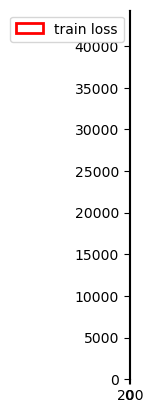

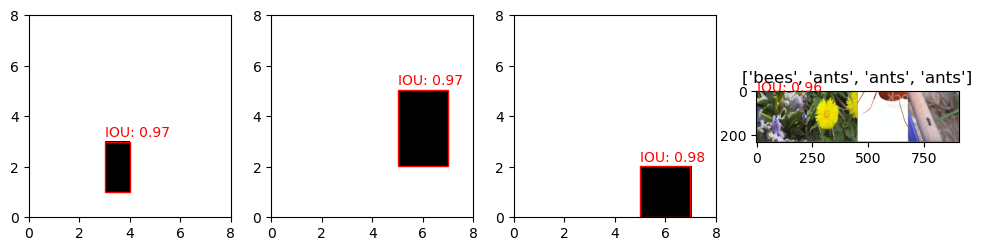

In [86]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [87]:
model_conv = models.inception_v3(pretrained=True)

/usr/shared/CMPT/big-data/condaenv/nn11/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/shared/CMPT/big-data/condaenv/nn11/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Answer for Task 2.2

In [88]:
# TODO paste and maybe modify relevant code to perform your own training
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)



In [89]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5268 Acc: 0.7172
val Loss: 0.3878 Acc: 0.8562

Epoch 1/24
----------
train Loss: 0.5893 Acc: 0.7582
val Loss: 0.2652 Acc: 0.9085

Epoch 2/24
----------
train Loss: 0.4099 Acc: 0.8156
val Loss: 0.3346 Acc: 0.8627

Epoch 3/24
----------
train Loss: 0.5965 Acc: 0.7500
val Loss: 0.4088 Acc: 0.8366

Epoch 4/24
----------
train Loss: 0.3872 Acc: 0.8402
val Loss: 0.2318 Acc: 0.9150

Epoch 5/24
----------
train Loss: 0.4247 Acc: 0.8197
val Loss: 0.8287 Acc: 0.7974

Epoch 6/24
----------
train Loss: 0.4703 Acc: 0.8361
val Loss: 0.3194 Acc: 0.8758

Epoch 7/24
----------
train Loss: 0.4620 Acc: 0.8279
val Loss: 0.1906 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.2901 Acc: 0.8730
val Loss: 0.1950 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.2770 Acc: 0.8689
val Loss: 0.1931 Acc: 0.9281

Epoch 10/24
----------
train Loss: 0.2644 Acc: 0.8852
val Loss: 0.2158 Acc: 0.9216

Epoch 11/24
----------
train Loss: 0.3460 Acc: 0.8566
val Loss: 0.2055 Acc: 0.9281

Ep

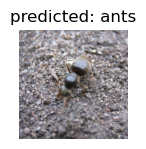

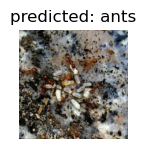

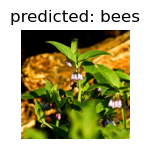

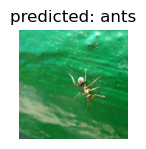

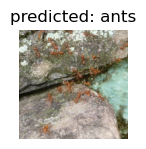

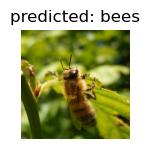

In [90]:
visualize_model(model_ft)

### Answer for Task 2.3

### Hints for this task

Focus on the section **Conv net as fixed feature xtractor** of the transfer learning tutorial.
First, change the line
```
model_conv = models.resnet18(pretrained=True)
```
to load VGG16 instead. Set all its parameters to *not* require gradient computation, as shown in the tutorial.

Next, print out the new `model_conv` and identify the last step of the classification. This is not named the same way as the ```fc``` layer for resnet, but it works similarily. The last classification step of the VGG model determines the probabilities for each of the 1000 classes of the dataset. Change this layer to identify only 2 classes to distinguish ants and bees as in the example.

To change the structure of some `Sequential` component called ```model_conv.module_name``` and to modify its last layer into a `DifferentLayer` type, you can use this syntax:

```
nn.Sequential(*list(model_conv.module_name.children())[:-1] +
                     [nn.DifferentLayer(...)])
```
and replace the old `model_conv.module_name` with this differently structured version.

In [91]:
# TODO
model_conv = torchvision.models.vgg16(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

In [92]:
model_conv

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [93]:
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.classifier[-1].in_features
model_conv.classifier[-1] = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.classifier[-1].parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [94]:
model_conv

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [95]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


train Loss: 0.2523 Acc: 0.8934
val Loss: 0.0894 Acc: 0.9673

Epoch 1/24
----------
train Loss: 0.1693 Acc: 0.9303
val Loss: 0.1096 Acc: 0.9542

Epoch 2/24
----------
train Loss: 0.1161 Acc: 0.9672
val Loss: 0.1443 Acc: 0.9608

Epoch 3/24
----------
train Loss: 0.1769 Acc: 0.9221
val Loss: 0.1282 Acc: 0.9542

Epoch 4/24
----------
train Loss: 0.1190 Acc: 0.9549
val Loss: 0.1687 Acc: 0.9477

Epoch 5/24
----------
train Loss: 0.1016 Acc: 0.9590
val Loss: 0.1473 Acc: 0.9412

Epoch 6/24
----------
train Loss: 0.1128 Acc: 0.9549
val Loss: 0.0883 Acc: 0.9608

Epoch 7/24
----------
train Loss: 0.1425 Acc: 0.9467
val Loss: 0.0846 Acc: 0.9673

Epoch 8/24
----------
train Loss: 0.1183 Acc: 0.9385
val Loss: 0.0847 Acc: 0.9608

Epoch 9/24
----------
train Loss: 0.0870 Acc: 0.9590
val Loss: 0.0835 Acc: 0.9673

Epoch 10/24
----------
train Loss: 0.0811 Acc: 0.9672
val Loss: 0.0851 Acc: 0.9673

Epoch 11/24
----------
train Loss: 0.1795 Acc: 0.9426
val Loss: 0.0890 Acc: 0.9673

Epoch 12/24
----------
t

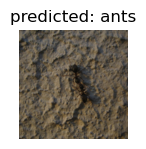

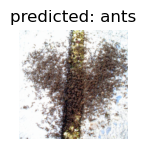

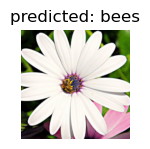

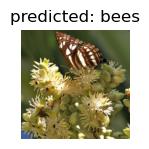

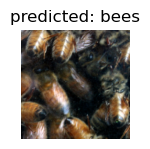

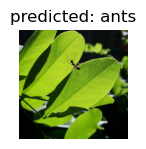

In [96]:
visualize_model(model_conv)

In [97]:
# TODO
model_conv2 = torchvision.models.vgg19(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

model_conv2

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [98]:
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv2.classifier[-1].in_features
model_conv2.classifier[-1] = nn.Linear(num_ftrs, 2)

model_conv2 = model_conv2.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv2.classifier[-1].parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [99]:
model_conv2

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

Epoch 0/24
----------


train Loss: 0.2849 Acc: 0.8893
val Loss: 0.1362 Acc: 0.9608

Epoch 1/24
----------
train Loss: 0.1622 Acc: 0.9303
val Loss: 0.1291 Acc: 0.9608

Epoch 2/24
----------
train Loss: 0.2650 Acc: 0.9098
val Loss: 0.0925 Acc: 0.9739

Epoch 3/24
----------
train Loss: 0.1700 Acc: 0.9344
val Loss: 0.0976 Acc: 0.9739

Epoch 4/24
----------
train Loss: 0.1422 Acc: 0.9467
val Loss: 0.0814 Acc: 0.9739

Epoch 5/24
----------
train Loss: 0.1522 Acc: 0.9426
val Loss: 0.1470 Acc: 0.9673

Epoch 6/24
----------
train Loss: 0.1048 Acc: 0.9672
val Loss: 0.0750 Acc: 0.9673

Epoch 7/24
----------
train Loss: 0.1418 Acc: 0.9467
val Loss: 0.0701 Acc: 0.9804

Epoch 8/24
----------
train Loss: 0.1319 Acc: 0.9385
val Loss: 0.0715 Acc: 0.9739

Epoch 9/24
----------
train Loss: 0.1181 Acc: 0.9590
val Loss: 0.0703 Acc: 0.9739

Epoch 10/24
----------
train Loss: 0.1234 Acc: 0.9467
val Loss: 0.0692 Acc: 0.9739

Epoch 11/24
----------
train Loss: 0.1352 Acc: 0.9467
val Loss: 0.0721 Acc: 0.9673

Epoch 12/24
----------
t

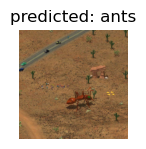

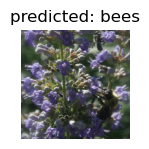

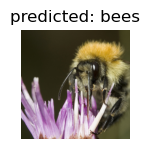

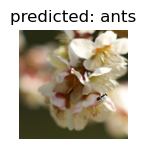

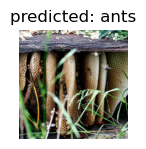

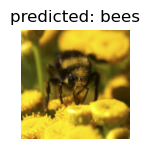

In [100]:
model_conv2 = train_model(model_conv2, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

visualize_model(model_conv2)

### Answer for Task 2.4

In [101]:
# TODO

# Load the model, weights, and put it into eval mode.
model = torchvision.models.vgg16(weights='IMAGENET1K_V1')  
model = model.to(device)
model.eval() 

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [103]:
from PIL import Image
import ast

class_name_path = '/home/mjk30/Documents/CMPT-733_DataScienceProgramming/A6/data/imagenet1000_clsidx_to_labels.txt'

def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        # Open the file and read its content
        with open(class_name_path, 'r') as file:
            file_content = file.read()

        # Use ast.literal_eval to safely evaluate the string as a Python dictionary
        class_names = ast.literal_eval(file_content)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0].item()]}')
        print(preds[0])
        imshow(img.cpu().data[0])
        
        model.train(mode=was_training)

tensor(259, device='cuda:0')


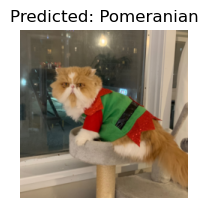

In [104]:
visualize_model_predictions(
    model,
    img_path='/home/mjk30/Documents/CMPT-733_DataScienceProgramming/A6/data/Squishy.jpeg'
)

plt.ioff()
plt.show()

Please include the picture so we can view it and its class label in the saved notebook. It's OK, if we don't have the actual image file to reproduce the output.

## Submission

Your submission should be based on a modified version of [this notebook](https://github.com/sfu-db/bigdata-cmpt733/blob/master/Assignments/A6/A6.ipynb) containing answers to Task 1 and for Task 2, saved with figures including some portions of the transfer learning tutorial notebook in the sections for tasks 2.1 - 2.4.